<a href="https://colab.research.google.com/github/blendaguedes/ml_analysis/blob/main/Stellar_Classification_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stellar Classificarion Analysis

This database is originaly from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)

It will classify

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics, decomposition, tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from dagster import op, In, Out, graph

In [258]:
sns.set(style="darkgrid")

In [259]:
df = pd.read_csv('star_classification.csv')

In [260]:
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [262]:
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [263]:
classes = list(df.groupby('class')['class'].count().index)
classes[1] = 'QUASARS'
classes_qnt = df.groupby('class')['class'].count().values

In [264]:
df.groupby('class')['class'].count()

class
GALAXY    59445
QSO       18961
STAR      21594
Name: class, dtype: int64

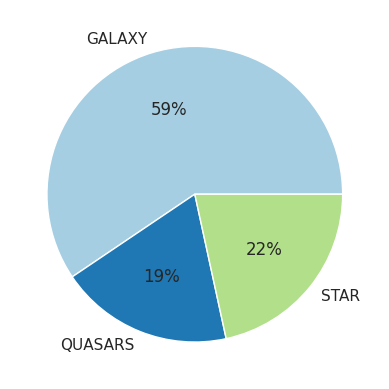

In [265]:
palette_color = sns.color_palette("Paired", 8)
plt.pie(classes_qnt, labels=classes, colors=palette_color, autopct='%.0f%%')
plt.show()

## Removing columns with only ID that won't be necessary features.

In [266]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [267]:
col_features = ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift', 'plate', 'MJD']

X = df[col_features].set_index('obj_ID')
y = df[['obj_ID', 'class']].set_index('obj_ID')

## Verifing data hist and quantils to look into outliers

In [268]:
def plot_feature_hist(X, col_features):
    figure, axes = plt.subplots(3, 4, figsize=(16, 10))
    plt.subplots_adjust(hspace = 0.8)
    feature_index = 0
    for i in range(4):
        for j in range(3):
            feature_index += 1
            if feature_index > 11: break
            feature = col_features[feature_index]
            sns.histplot(data=X, x=feature, kde=True, bins=10, ax=axes[j][i]).set(title=feature)
        if feature_index > 11: break
    plt.show()

def plot_feature_quartil(X, col_features):
    figure, axes = plt.subplots(3, 4, figsize=(16, 10), dpi=200)
    plt.subplots_adjust(hspace = 0.8)
    feature_index = 0
    for i in range(4):
        for j in range(3):
            feature_index += 1
            if feature_index > 11: break
            feature = col_features[feature_index]
            sns.boxplot(data=X, x=feature, ax=axes[j][i])
        if feature_index > 11: break
    plt.show()


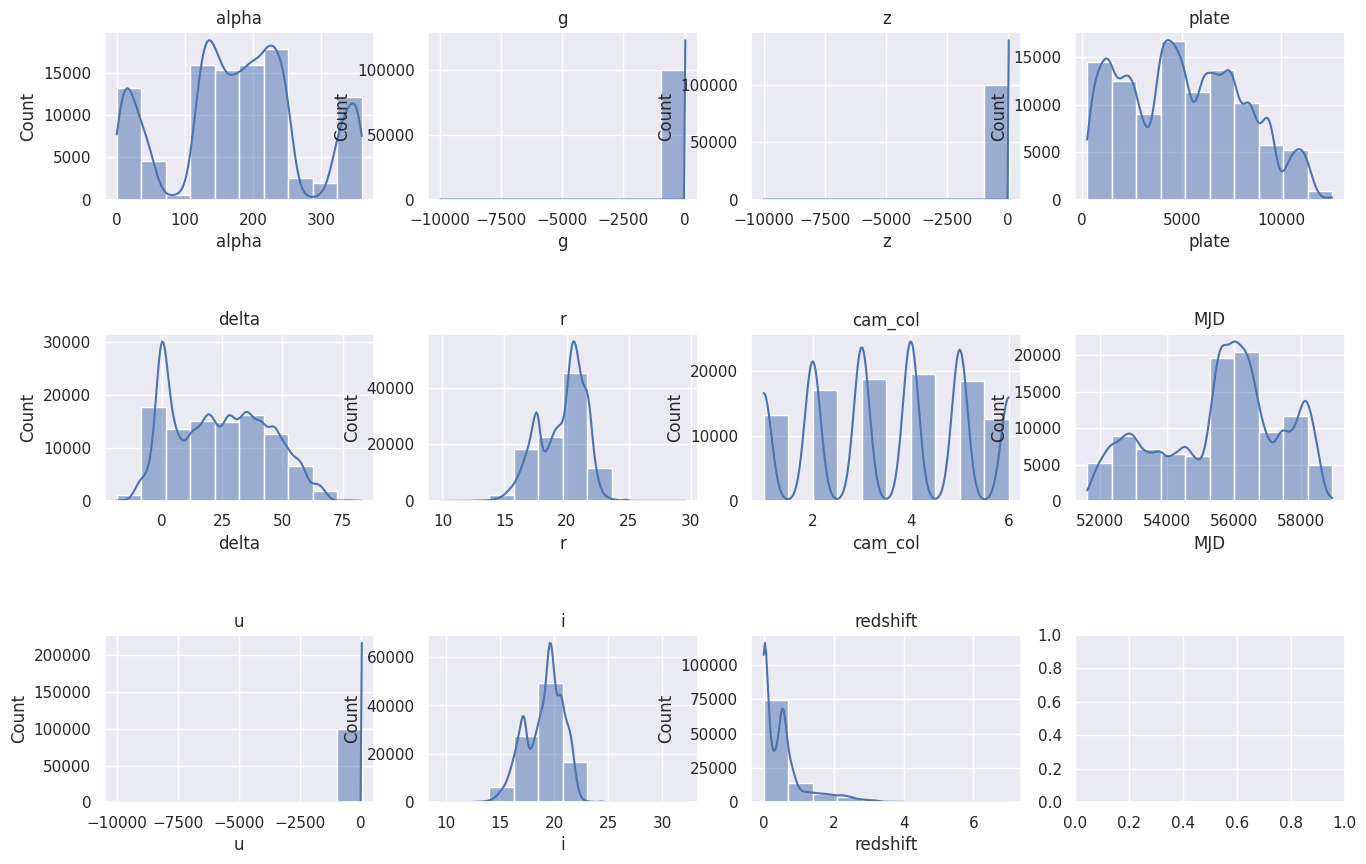

In [269]:
plot_feature_hist(X, col_features)

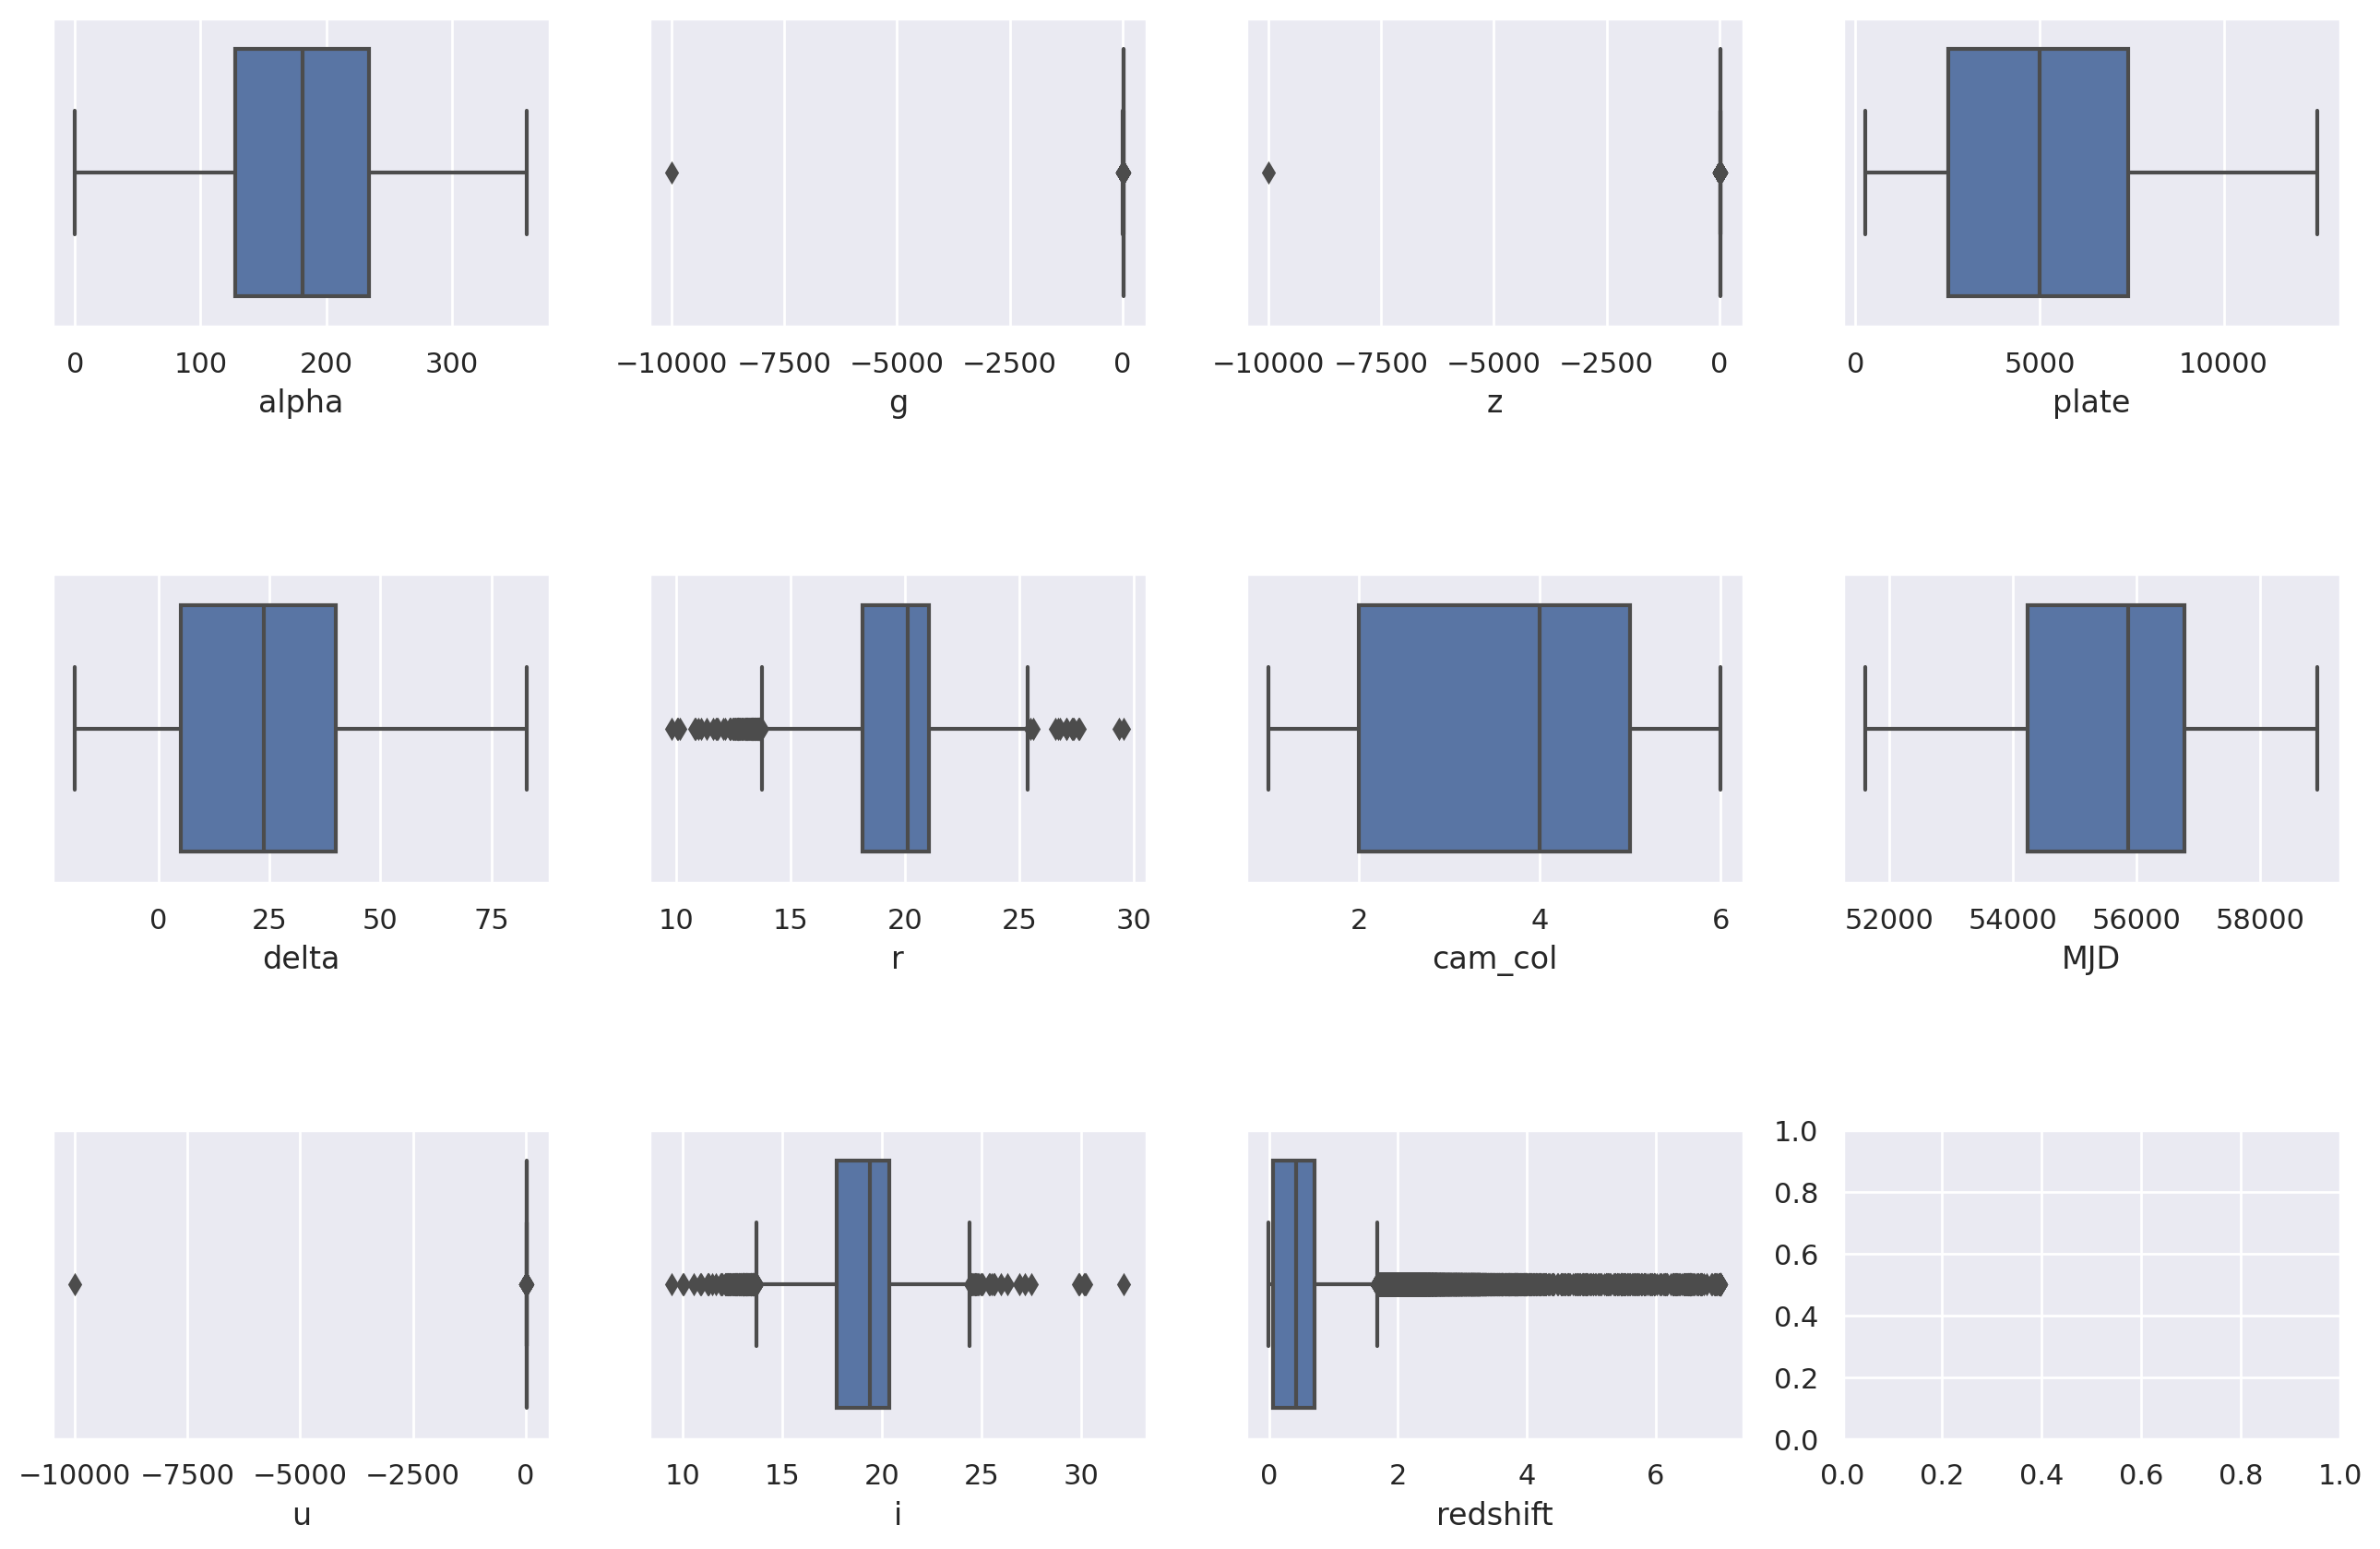

In [270]:
plot_feature_quartil(X, col_features)

Removing outlier from g, u and z

In [271]:
X[X['u']<X['u'].min()+1].index[0] == X[X['g']<X['g'].min()+1].index[0] == X[X['z']<X['z'].min()+1].index[0]

True

In [272]:
outlier = X[X['u']<X['u'].min()+1].index[0]
X = X.drop(outlier)

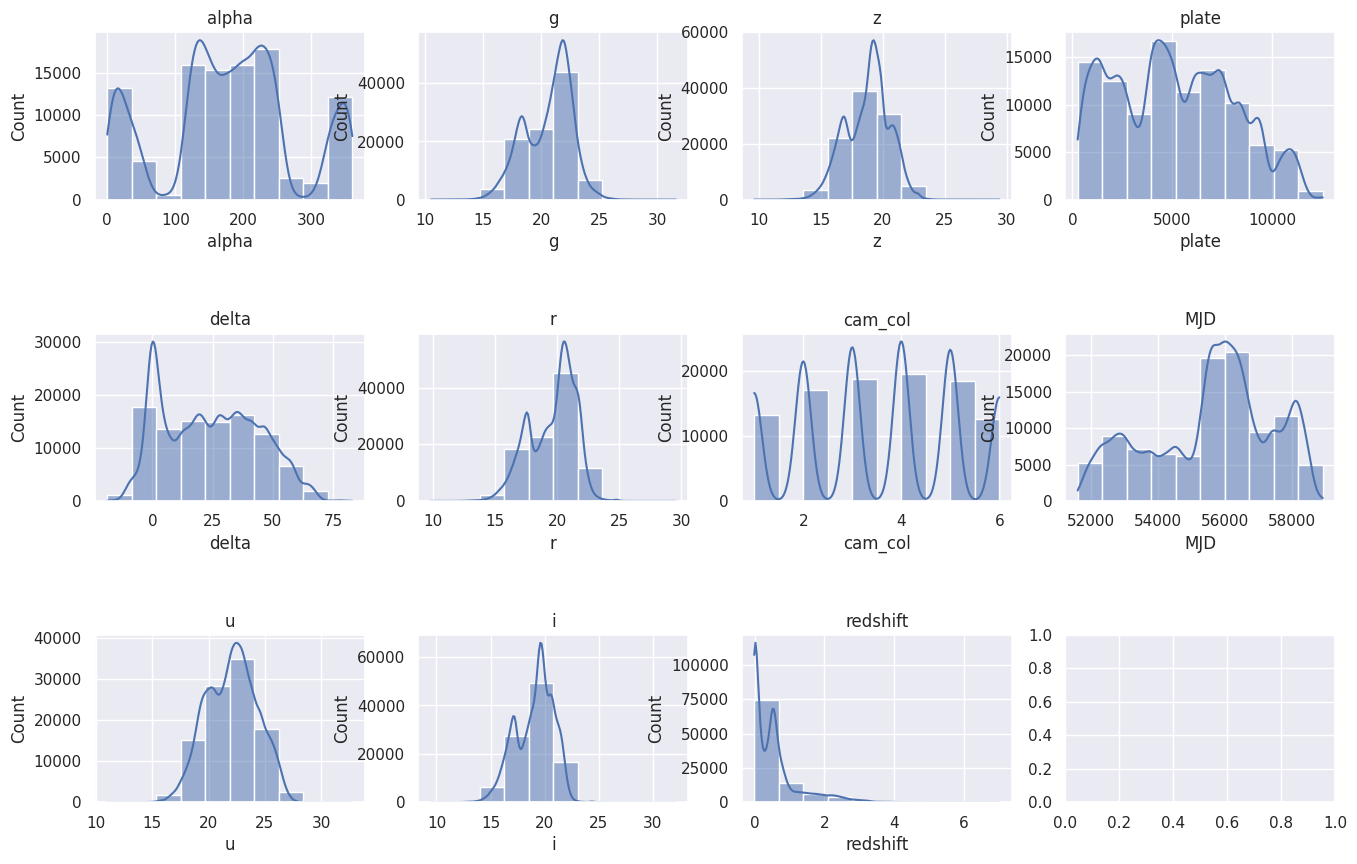

In [273]:
plot_feature_hist(X, col_features)

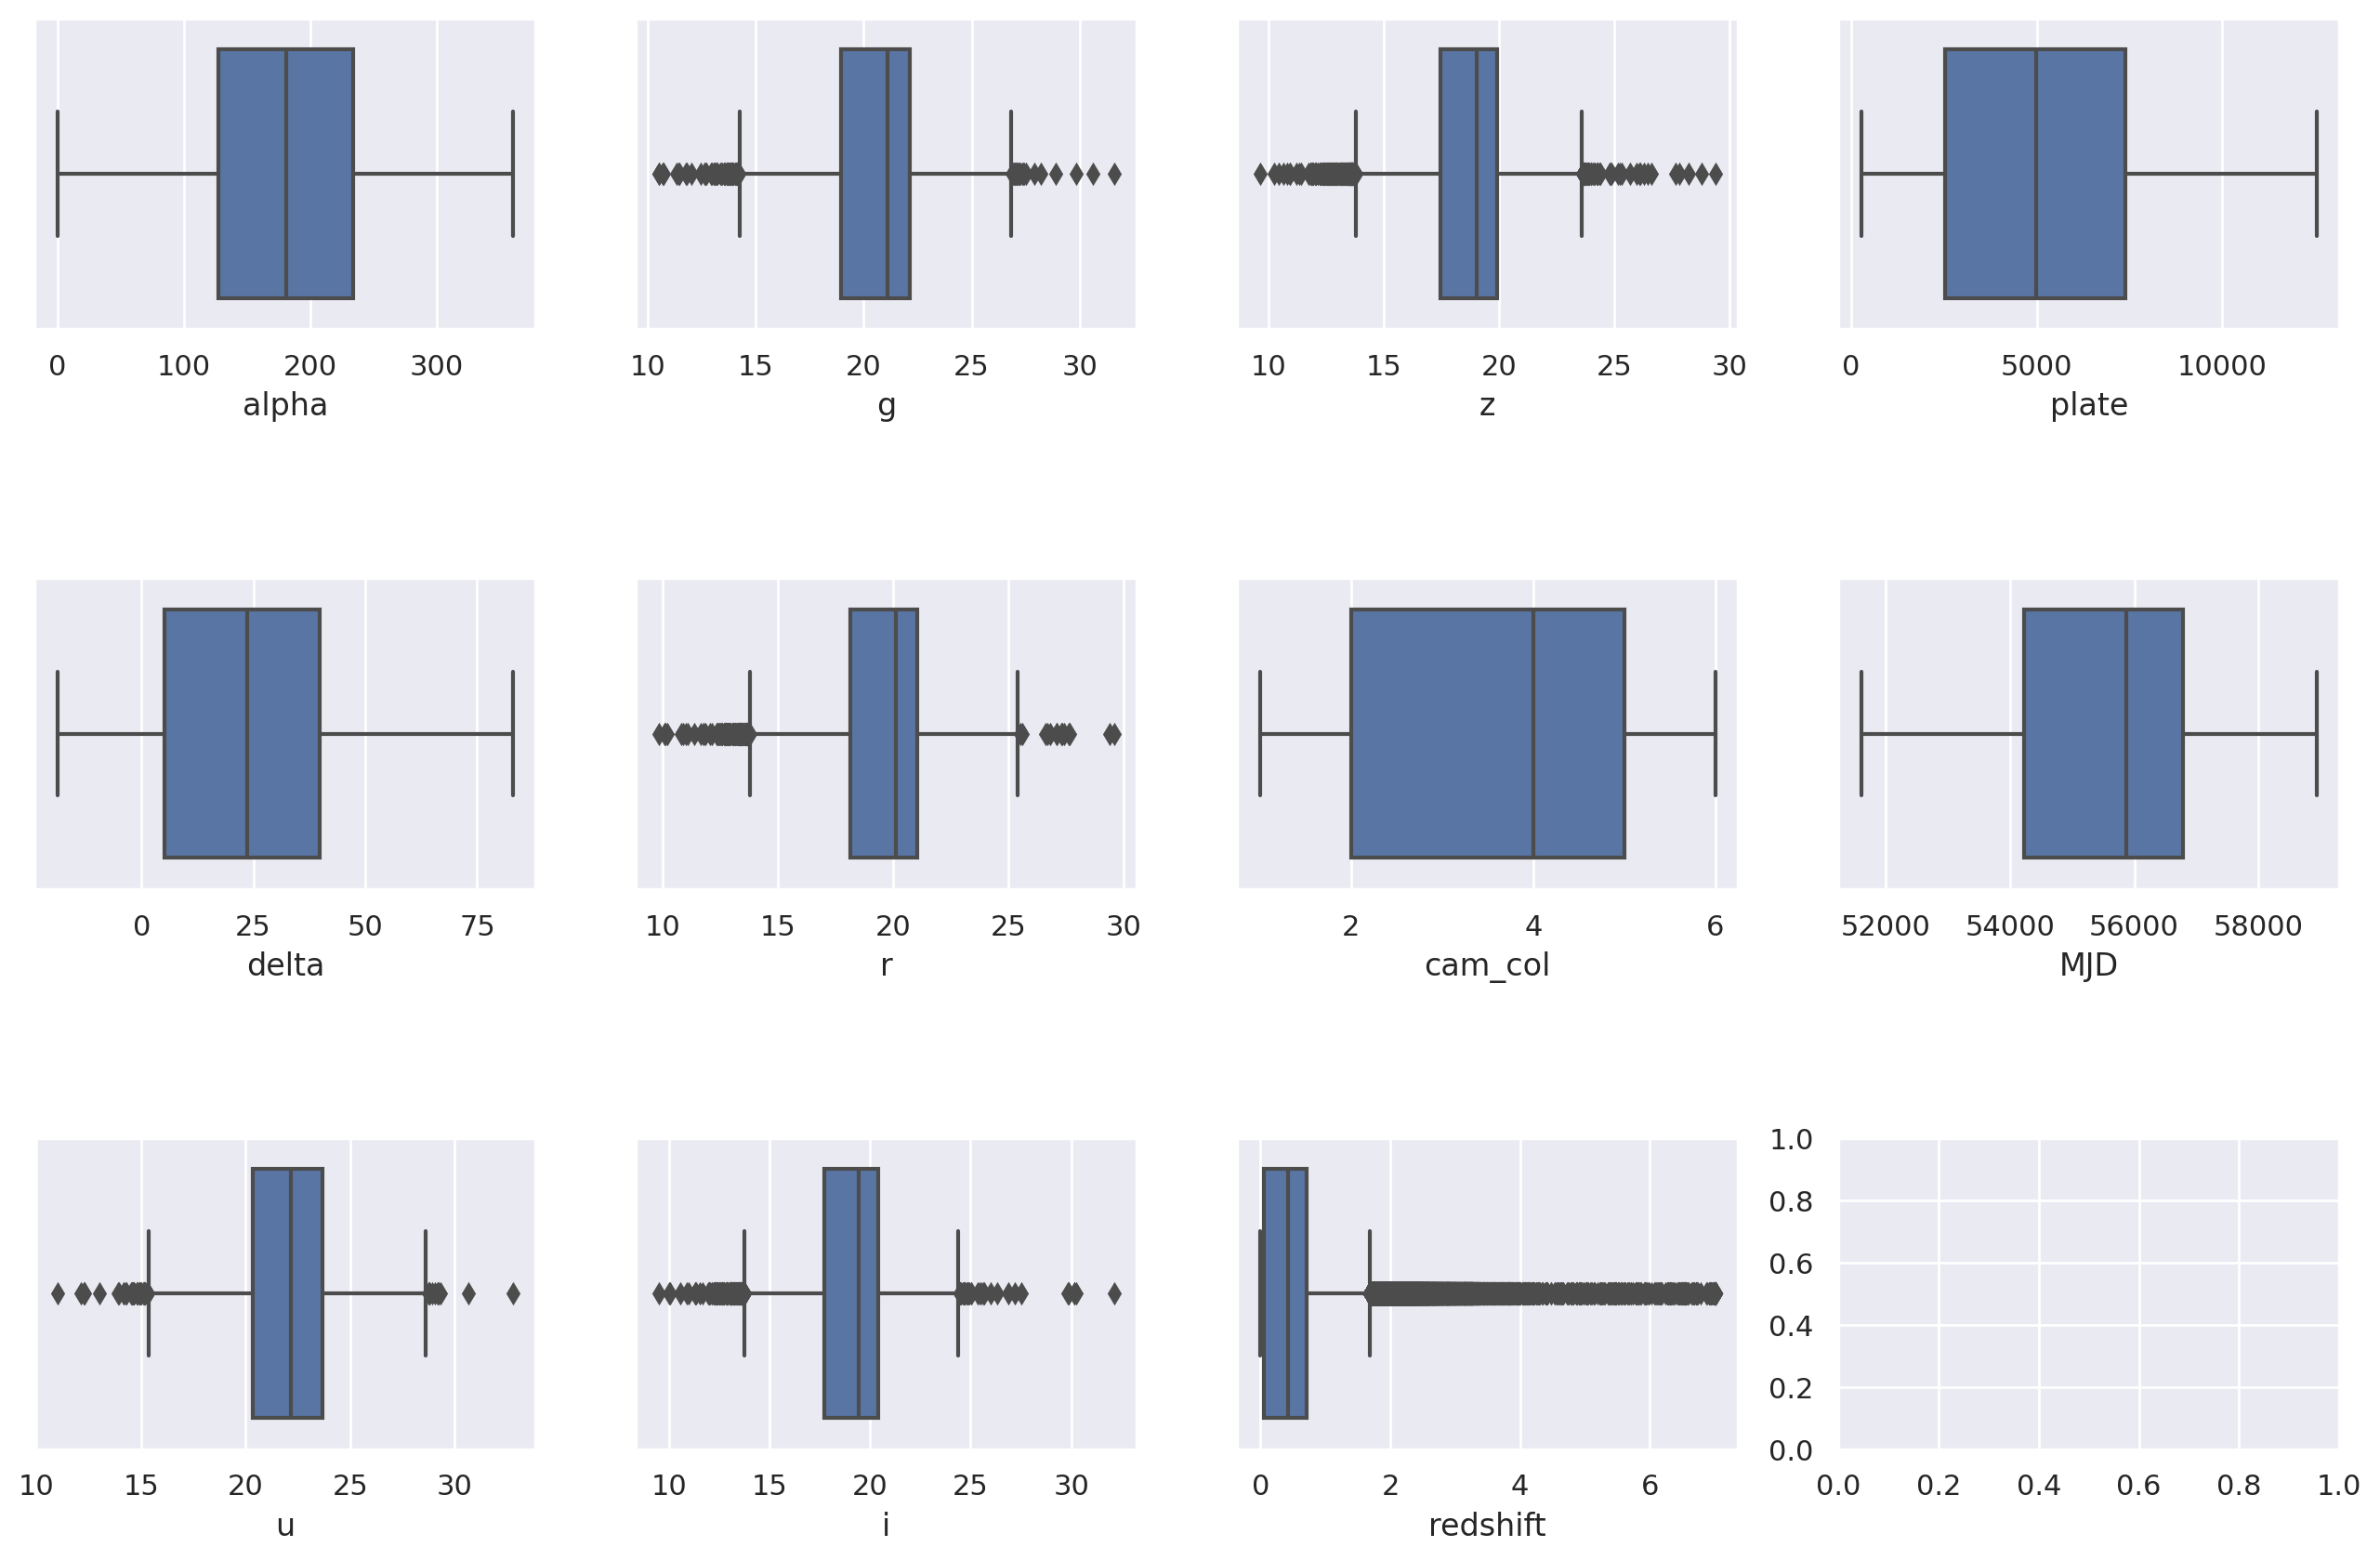

In [274]:
plot_feature_quartil(X, col_features)

# Compiling data preparation into methods to create a pipeline

In [275]:
def import_data(file_path: str) -> pd.DataFrame:
    data = pd.read_csv(file_path)
    return data

def clean(data: pd.DataFrame) -> pd.DataFrame:
    outlier = data[data['u']<data['u'].min()+1].index[0]
    data = data.drop(outlier)
    return data

def select_features(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    col_features = ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift', 'plate', 'MJD']

    X = data[col_features].set_index('obj_ID')
    y = data[['obj_ID', 'class']].set_index('obj_ID')

    return X, y

def preprocess_pipeline() -> tuple[pd.DataFrame, pd.DataFrame]:
    file = 'star_classification.csv'
    data = import_data(file)
    len(data)
    data = clean(data)
    X, y = select_features(data)
    return X, y


In [276]:
X, y = preprocess_pipeline()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Runnig Decision Tree classifier with GridSearch and Cross Validation:

---



In [277]:
clf = DecisionTreeClassifier(random_state=2)

criterion = ['gini', 'entropy']
max_depth = [2, 4, 6, 8, 10, 12]
ccp_alpha = [0.001, 0.01]

parameters = {'criterion':criterion,
              'max_depth':max_depth,
              'ccp_alpha': ccp_alpha}

Since the model will have a high number of input values and we are already using ccp_alpha only changing the max_depth will be enough to verification

In [278]:
clf_GS = GridSearchCV(clf, parameters)
clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=2),
             param_grid={'ccp_alpha': [0.001, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]})



Model evoluation


In [279]:
y_pred = clf_GS.best_estimator_.predict(X_test)

In [280]:
y_test['class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [281]:
y_test.groupby('class')['class'].count()

class
GALAXY    8879
QSO       2836
STAR      3285
Name: class, dtype: int64

In [282]:
metrics.multilabel_confusion_matrix(y_test, y_pred, labels=['GALAXY', 'QSO', 'STAR'])

array([[[ 5872,   249],
        [  139,  8740]],

       [[12041,   123],
        [  243,  2593]],

       [[11698,    17],
        [    7,  3278]]])

In [283]:
print("Precision for GALAXY, QUASAR AND STAR: ", *metrics.precision_score(y_test, y_pred, labels=['GALAXY', 'QSO', 'STAR'], average=None))
print("Precision for GALAXY, QUASAR AND STAR: ", metrics.accuracy_score(y_test, y_pred))


Precision for GALAXY, QUASAR AND STAR:  0.9722994771387251 0.9547128129602357 0.9948406676783005
Precision for GALAXY, QUASAR AND STAR:  0.9740666666666666


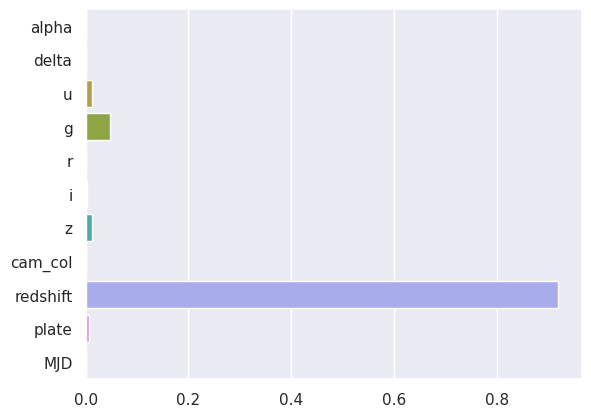

In [284]:
sns.barplot(y=X_train.columns, x=clf_GS.best_estimator_.feature_importances_)
plt.show()

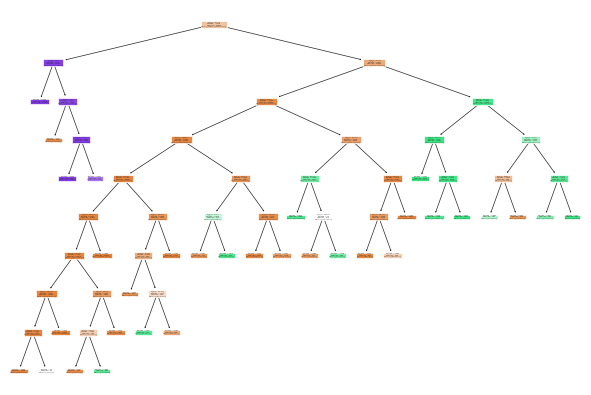

In [285]:
plt.figure(figsize=(15, 10), dpi=50)
tree.plot_tree(clf_GS.best_estimator_, filled=True)
plt.show()